### Sparseness analysis of argo data

In [1]:
%matplotlib inline
#BASICS
import numpy as np
import pandas as pd
#CARTOPY
import cartopy.geodesic
geod = cartopy.geodesic.Geodesic()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
#MATPLOTLIB
import matplotlib.pyplot as plt

In [2]:
# Distance calculation fonction with cartopy geodesic
def dist(p1,p2):
    d,a1,a2 = np.array(geod.inverse(p1,p2).T)
    return d[0]/1000.0

#### First we read our data = argo profiles index, and make it a pandas dataframe

In [3]:
# DAT=pd.read_csv('/home/oo26/coriolis/co05/co0508/ar_index_global_prof.txt',sep=',', index_col=None, 
#                   header=0, skiprows=8,parse_dates=[1, 7])
DAT=pd.read_csv('ftp://ftp.ifremer.fr/ifremer/argo/ar_index_global_prof.txt',sep=',', index_col=None, 
                  header=0, skiprows=8,parse_dates=[1, 7])

#### Then we do some stuff with the dataframe

In [5]:
# GENERATE FLOAT NUMBER FROM FILE
DAT['FloatNumber'] = DAT.file.apply(lambda x: int(x.split('/')[1]))
#LAST PROFILE OF ACTIVE FLOATS
LDAT=DAT.groupby('FloatNumber').last()
ADAT=LDAT[LDAT.date > np.datetime64('2019-12-10')]
ADAT=ADAT[~ADAT.latitude.isnull() & ~ADAT.longitude.isnull()]
ADAT=ADAT.query('longitude >= -180 & longitude <= 180 & latitude >= -90 & latitude <= 90')

#### We calculate the distance between a float and its 4 neighbors (scikit learn lib)

In [6]:
# NEARNEIGHBOR SCIKIT-LEARN
from sklearn.neighbors import NearestNeighbors

#CURRENT ACTIVE PROFILES 
points = list(zip(ADAT['longitude'].values,ADAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
indices = nbrs.kneighbors(points,return_distance=False)

distancem=np.empty_like(indices)
distances=np.empty(len(ADAT))
dtot=0;
for i in range(indices.shape[0]):
    di=0
    for j in [1,2,3,4]:
        distancem[i,j]=dist(np.array([ADAT['longitude'].values[i],ADAT['latitude'].values[i]]),
                            np.array([ADAT['longitude'].values[indices[i,j]],ADAT['latitude'].values[indices[i,j]]]))
        di+=distancem[i,j]
    di=di/4
    distances[i]=di
    dtot+=di    
dtot=dtot/len(ADAT)    
print("Average distance from a float to its closest buddy :",dtot," km")

Average distance from a float to its closest buddy : 237.6776282051282  km


#### Then we grid those distances over atlantic area

In [7]:
from scipy.interpolate import griddata

x = np.arange(-100,41,1.0)
y = np.arange(-70,80,1.0)
grid_x, grid_y = np.meshgrid(x, y)
grid_z=griddata((ADAT['longitude'].values,ADAT['latitude'].values),distances,(grid_x,grid_y),method='cubic')

#### Here we retrieve cells (3x3°) where there are no data, to hide them in the plot 

In [8]:
bx = np.arange(-100,41,3.0)
by = np.arange(-70,80,3.0)
H1, xedges, yedges=np.histogram2d(ADAT['longitude'].values,ADAT['latitude'].values,bins=(bx,by))
G1=np.empty_like(H1)*np.nan
for i in range(H1.shape[0]):
    for j in range(H1.shape[1]):
        if H1[i,j]==0. :
            G1[i,j]=1              

#### and we plot

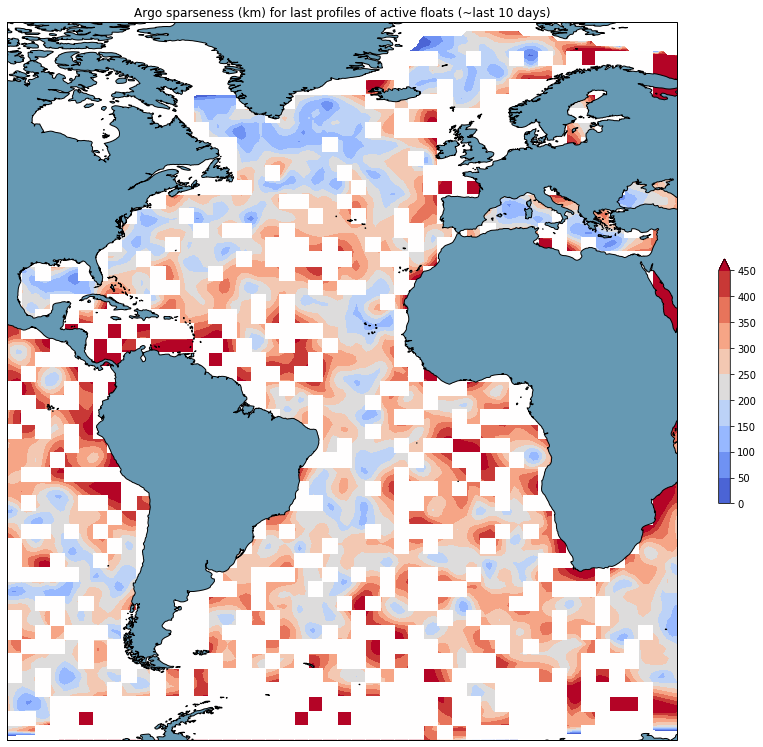

In [28]:
fig=plt.figure(figsize=(15,15))
pr1=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=pr1)
hh=ax.contourf(grid_x,grid_y,grid_z,np.arange(0,500,50),cmap='coolwarm',extend='max')
ax.add_feature(land_feature, edgecolor='black')
plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.05)
ax.pcolormesh(bx[0:-1],by[0:-1],G1.T,cmap='bwr',vmin=0.,vmax=2.)
#ax.plot(ADAT['longitude'].values,ADAT['latitude'].values,'k.',markersize=0.5)
ax.set_extent([-100, 40, -70, 80], crs=pr1)
plt.title('Argo sparseness (km) for last profiles of active floats (~last 10 days)')
plt.show()

### SAME FOR ANOTHER SET OF DATA

In [378]:
#ANOTHER TIME SELECTION
MDAT=DAT.query('date >= "2019-01-01" & date <= "2019-12-31"')
MDAT=MDAT[~MDAT.latitude.isnull() & ~MDAT.longitude.isnull()]
MDAT=MDAT.query('longitude >= -180 & longitude <= 180 & latitude >= -90 & latitude <= 90')
MDAT.head()

,file,date,latitude,longitude,ocean,profiler_type,institution,date_update,FloatNumber
44097,aoml/1900726/profiles/D1900726_402.nc,2019-01-10 09:08:33,-24.269,-131.992,P,846,AO,2019-12-10 13:41:12,1900726
44098,aoml/1900726/profiles/D1900726_403.nc,2019-01-20 10:35:19,-24.248,-132.182,P,846,AO,2019-12-10 13:41:12,1900726
44099,aoml/1900726/profiles/D1900726_404.nc,2019-01-30 17:06:31,-24.375,-132.224,P,846,AO,2019-12-10 13:41:12,1900726
44100,aoml/1900726/profiles/D1900726_405.nc,2019-02-09 18:34:01,-24.499,-132.327,P,846,AO,2019-12-10 13:41:13,1900726
44101,aoml/1900726/profiles/D1900726_406.nc,2019-02-19 22:54:43,-24.646,-132.544,P,846,AO,2019-12-10 13:41:13,1900726


In [403]:
#NEARNEIGHBOR
points = list(zip(MDAT['longitude'].values,MDAT['latitude'].values))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(points)
indices = nbrs.kneighbors(points,return_distance=False)

distancem=np.empty_like(indices)
distances2=np.empty(len(MDAT))
dtot=0;
for i in range(indices.shape[0]):
    di=0
    for j in [1,2,3,4]:
        distancem[i,j]=dist(np.array([MDAT['longitude'].values[i],MDAT['latitude'].values[i]]),
                            np.array([MDAT['longitude'].values[indices[i,j]],MDAT['latitude'].values[indices[i,j]]]))
        di+=distancem[i,j]
    di=di/4.0
    distances2[i]=di
    dtot+=di    
dtot=dtot/len(MDAT)    
print("Average distance from a float to its closest buddy :",dtot," km")

Average distance from a float to its closest buddy : 24.692699174159713  km


In [380]:
from scipy.interpolate import griddata
grid_z2=griddata((MDAT['longitude'].values,MDAT['latitude'].values),distances2,(grid_x,grid_y),method='cubic')

In [381]:
H2, xedges, yedges=np.histogram2d(MDAT['longitude'].values,MDAT['latitude'].values,bins=(bx,by))
G2=np.empty_like(H2)*np.nan
for i in range(H2.shape[0]):
    for j in range(H2.shape[1]):
        if H2[i,j]==0. :
            G2[i,j]=1  

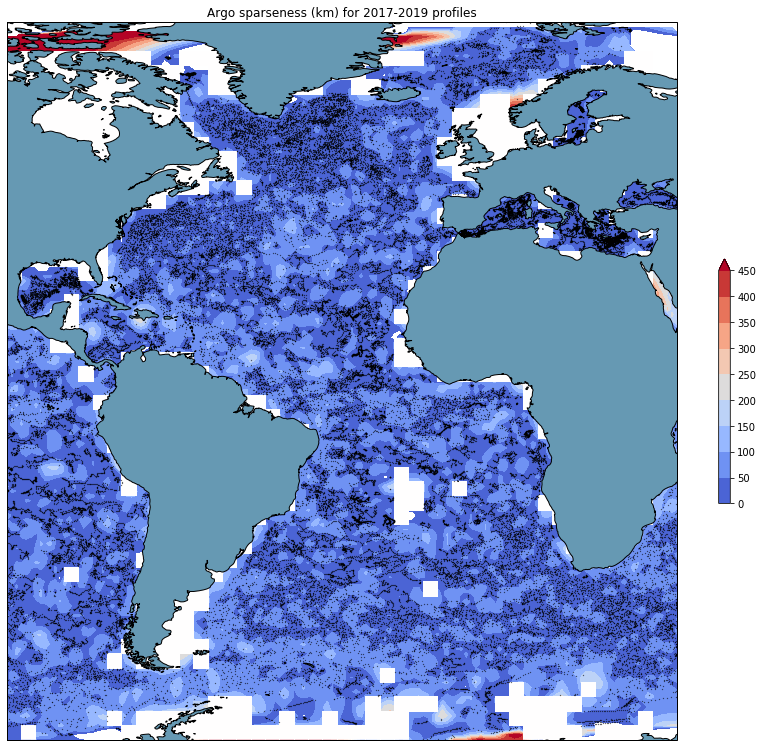

In [395]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
hh=ax.contourf(grid_x,grid_y,grid_z2,np.arange(0,500,50),cmap='coolwarm',extend='max')
ax.add_feature(land_feature, edgecolor='black')
plt.colorbar(hh,orientation= 'vertical', shrink=0.3, pad=0.05)
ax.pcolormesh(bx[0:-1],by[0:-1],G2.transpose(),cmap='bwr',vmin=0.,vmax=2.)
ax.plot(MDAT['longitude'].values,MDAT['latitude'].values,'k.',markersize=0.5)
ax.set_extent([-100, 40, -70, 80], crs=ccrs.PlateCarree())
plt.title('Argo sparseness (km)')
plt.show()
